# BEVFormer++ Training Visualization

This notebook is a **visualization layer only**. It does NOT implement training logic.

**Contract:**
- `train.py` is the single source of truth for training
- This notebook runs training via subprocess and visualizes results
- All configs live under `configs/`

## Workflow
1. Configure experiment (config file, overrides, budget)
2. Run training via `train.py` subprocess
3. Load JSONL logs and visualize curves
4. Display summary statistics

## 1. Environment & Configuration

In [19]:
# Environment Setup
import subprocess
import sys
import os
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we're in the project root
PROJECT_ROOT = Path.cwd()
print(f"Project root: {PROJECT_ROOT}")
print(f"Python: {sys.executable}")

# Check for GPU (informational only - training runs in subprocess)
try:
    import torch
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    else:
        print("GPU: Not available (will use CPU)")
except ImportError:
    print("PyTorch not available in notebook environment")

Project root: /mnt/d/code/bev/bevformerpp
Python: /mnt/d/code/bev/bevformerpp/.venv/bin/python
GPU: NVIDIA GeForce RTX 5070 Ti
Memory: 17.1 GB


In [20]:
# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================
# Modify these settings to configure your training run

# Path to YAML config file (relative to project root)
CONFIG_PATH = "configs/debug.yaml"

# CLI overrides (list of strings in format "--arg value" or "--flag")
# Example: ["--temporal_method", "mc_convrnn", "--use_fusion"]
OVERRIDES = []

# Training budget
EPOCHS = 3          # Number of epochs (use small value for quick tests)
BATCH_SIZE = 1      # Batch size
MAX_STEPS = None    # Max training steps (None = run all epochs, set int for quick debug)
SEED = 42           # Random seed for reproducibility

# Logging settings
LOG_EVERY_N_STEPS = 1  # Log every N training steps

# Output paths (auto-generated)
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = Path("outputs") / f"run_{RUN_ID}"
JSONL_LOG_PATH = OUTPUT_DIR / "train_log.jsonl"
JSON_LOG_PATH = OUTPUT_DIR / "epoch_summary.json"

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Run ID: {RUN_ID}")
print(f"Config: {CONFIG_PATH}")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Max Steps: {MAX_STEPS}")
print(f"Overrides: {OVERRIDES if OVERRIDES else 'None'}")
print(f"Output directory: {OUTPUT_DIR}")

Run ID: 20260102_154222
Config: configs/debug.yaml
Epochs: 3, Batch Size: 1, Max Steps: None
Overrides: None
Output directory: outputs/run_20260102_154222


## 2. Run Training via train.py

In [21]:
def build_train_command(
    config_path,
    epochs,
    batch_size,
    seed,
    jsonl_log_path,
    json_log_path,
    log_every_n_steps=1,
    max_steps=None,
    overrides=None,
):
    """Build the train.py command with all arguments."""
    cmd = [
        sys.executable, "train.py",
        "--config", str(config_path),
        "--epochs", str(epochs),
        "--batch_size", str(batch_size),
        "--seed", str(seed),
        "--log_jsonl_path", str(jsonl_log_path),
        "--log_json_path", str(json_log_path),
        "--log_every_n_steps", str(log_every_n_steps),
    ]
    
    if max_steps is not None:
        cmd.extend(["--max_steps", str(max_steps)])
    
    if overrides:
        cmd.extend(overrides)
    
    return cmd


def run_training(cmd, cwd=None):
    """Run training command and capture output."""
    print("=" * 80)
    print("EXECUTING COMMAND:")
    print(" ".join(str(x) for x in cmd))
    print("=" * 80)
    
    result = subprocess.run(
        cmd,
        cwd=cwd or PROJECT_ROOT,
        capture_output=True,
        text=True,
    )
    
    return {
        'returncode': result.returncode,
        'stdout': result.stdout,
        'stderr': result.stderr,
        'success': result.returncode == 0,
    }


# Build and display the command
train_cmd = build_train_command(
    config_path=CONFIG_PATH,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    seed=SEED,
    jsonl_log_path=JSONL_LOG_PATH,
    json_log_path=JSON_LOG_PATH,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    overrides=OVERRIDES,
)

print("Command to execute:")
print(" ".join(str(x) for x in train_cmd))

Command to execute:
/mnt/d/code/bev/bevformerpp/.venv/bin/python train.py --config configs/debug.yaml --epochs 3 --batch_size 1 --seed 42 --log_jsonl_path outputs/run_20260102_154222/train_log.jsonl --log_json_path outputs/run_20260102_154222/epoch_summary.json --log_every_n_steps 1


In [22]:
# Run training
print(f"Starting training at {datetime.now().strftime('%H:%M:%S')}...")
print()

result = run_training(train_cmd)

print()
print("=" * 80)
print("TRAINING OUTPUT:")
print("=" * 80)
print(result['stdout'])

if result['stderr']:
    print("\n" + "=" * 80)
    print("STDERR:")
    print("=" * 80)
    print(result['stderr'])

if result['success']:
    print("\n✅ Training completed successfully!")
else:
    print(f"\n❌ Training failed with return code: {result['returncode']}")

Starting training at 15:42:22...

EXECUTING COMMAND:
/mnt/d/code/bev/bevformerpp/.venv/bin/python train.py --config configs/debug.yaml --epochs 3 --batch_size 1 --seed 42 --log_jsonl_path outputs/run_20260102_154222/train_log.jsonl --log_json_path outputs/run_20260102_154222/epoch_summary.json --log_every_n_steps 1

TRAINING OUTPUT:
Starting camera-only training on cuda...
Temporal method: convgru
Curriculum schedule: Stage 1 (hard_center) for epochs 0-1, Stage 2 (gaussian) for epochs 2+
Stage 1 params: pos_weight=50.0, gaussian_overlap=0.01, min_radius=1
Stage 2 params: pos_weight=10.0, gaussian_overlap=0.1, min_radius=2
Loading NuScenes Dataset from data...
Dataset sizes: Train=283, Val=81, Test=40
Using EnhancedBEVFormer (camera-only) with convgru
✓ Target generation will use curriculum schedule (starts with heatmap_mode='hard_center')

[CURRICULUM] Initializing Stage 1 at epoch 1
[CURRICULUM]
  epoch=1
  heatmap_mode=hard_center
  gaussian_overlap=0.01
  min_radius=1
  cls_loss:
  

## 3. Load and Parse Logs

In [23]:
def load_jsonl_logs(filepath):
    """Load JSONL logs into a pandas DataFrame."""
    if not filepath.exists():
        print(f"Warning: Log file not found: {filepath}")
        return pd.DataFrame()
    
    events = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    events.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Warning: Failed to parse line: {e}")
    
    if not events:
        return pd.DataFrame()
    
    return pd.DataFrame(events)


def load_epoch_summary(filepath):
    """Load epoch summary JSON."""
    if not filepath.exists():
        print(f"Warning: Summary file not found: {filepath}")
        return []
    
    with open(filepath, 'r') as f:
        return json.load(f)


# Load logs
df_logs = load_jsonl_logs(JSONL_LOG_PATH)
epoch_summary = load_epoch_summary(JSON_LOG_PATH)

print(f"Loaded {len(df_logs)} log events")
print(f"Loaded {len(epoch_summary)} epoch summaries")

if len(df_logs) > 0:
    print("\nEvent types:")
    print(df_logs['event'].value_counts())

Loaded 856 log events
Loaded 3 epoch summaries

Event types:
event
step      849
epoch       6
config      1
Name: count, dtype: int64


In [24]:
# Extract step-level and epoch-level data
if len(df_logs) > 0:
    # Config event
    df_config = df_logs[df_logs['event'] == 'config']
    if len(df_config) > 0:
        config_info = df_config.iloc[0].to_dict()
        print("Training Configuration:")
        for k, v in config_info.items():
            if k not in ['event', 'time']:
                print(f"  {k}: {v}")
    
    # Step events (training)
    df_steps = df_logs[(df_logs['event'] == 'step') & (df_logs['split'] == 'train')].copy()
    print(f"\nTraining steps logged: {len(df_steps)}")
    
    # Epoch events
    df_epochs_train = df_logs[(df_logs['event'] == 'epoch') & (df_logs['split'] == 'train')].copy()
    df_epochs_val = df_logs[(df_logs['event'] == 'epoch') & (df_logs['split'] == 'val')].copy()
    print(f"Training epochs: {len(df_epochs_train)}")
    print(f"Validation epochs: {len(df_epochs_val)}")
else:
    df_steps = pd.DataFrame()
    df_epochs_train = pd.DataFrame()
    df_epochs_val = pd.DataFrame()

Training Configuration:
  epochs: 3.0
  batch_size: 1.0
  lr: 0.0001
  temporal_method: convgru
  use_fusion: False
  seed: 42.0
  run_dir: nan
  split: nan
  epoch: nan
  global_step: nan
  batch_idx: nan
  loss_total: nan
  loss_cls: nan
  loss_bbox: nan

Training steps logged: 849
Training epochs: 3
Validation epochs: 3


## 4. Visualize Training Curves

Plot saved to: outputs/run_20260102_154222/training_curves.png


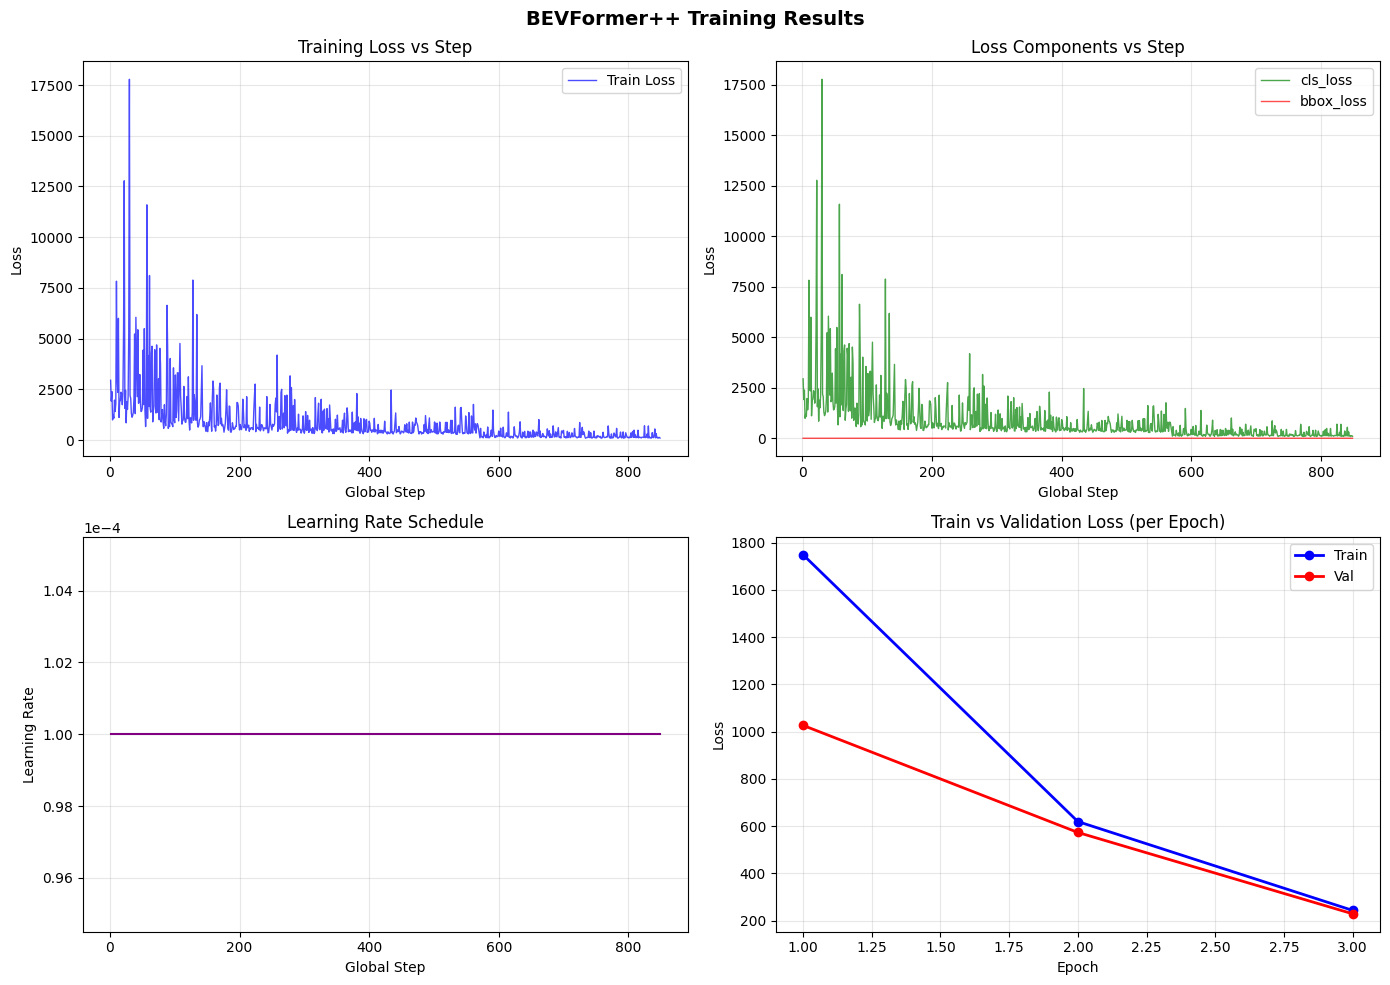

In [25]:
def plot_training_curves(df_steps, df_epochs_train, df_epochs_val, save_path=None):
    """Plot training curves from logged data."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Training Loss (step-level)
    ax = axes[0, 0]
    if len(df_steps) > 0 and 'global_step' in df_steps.columns:
        ax.plot(df_steps['global_step'], df_steps['loss_total'], 'b-', alpha=0.7, linewidth=1, label='Train Loss')
        ax.set_xlabel('Global Step')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss vs Step')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No step-level data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Training Loss vs Step')
    
    # Plot 2: Loss Components (step-level)
    ax = axes[0, 1]
    if len(df_steps) > 0 and 'loss_cls' in df_steps.columns:
        ax.plot(df_steps['global_step'], df_steps['loss_cls'], 'g-', alpha=0.7, linewidth=1, label='cls_loss')
        ax.plot(df_steps['global_step'], df_steps['loss_bbox'], 'r-', alpha=0.7, linewidth=1, label='bbox_loss')
        ax.set_xlabel('Global Step')
        ax.set_ylabel('Loss')
        ax.set_title('Loss Components vs Step')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No component data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Loss Components vs Step')
    
    # Plot 3: Learning Rate
    ax = axes[1, 0]
    if len(df_steps) > 0 and 'lr' in df_steps.columns:
        ax.plot(df_steps['global_step'], df_steps['lr'], 'purple', linewidth=1.5)
        ax.set_xlabel('Global Step')
        ax.set_ylabel('Learning Rate')
        ax.set_title('Learning Rate Schedule')
        ax.grid(True, alpha=0.3)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    else:
        ax.text(0.5, 0.5, 'No LR data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Learning Rate Schedule')
    
    # Plot 4: Epoch-level Train vs Val Loss
    ax = axes[1, 1]
    if len(df_epochs_train) > 0:
        epochs = df_epochs_train['epoch'].values
        ax.plot(epochs, df_epochs_train['loss_total'].values, 'b-o', linewidth=2, markersize=6, label='Train')
        if len(df_epochs_val) > 0:
            ax.plot(df_epochs_val['epoch'].values, df_epochs_val['loss_total'].values, 'r-o', linewidth=2, markersize=6, label='Val')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Train vs Validation Loss (per Epoch)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No epoch data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Train vs Validation Loss (per Epoch)')
    
    plt.suptitle('BEVFormer++ Training Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()


# Plot training curves
plot_path = OUTPUT_DIR / "training_curves.png"
plot_training_curves(df_steps, df_epochs_train, df_epochs_val, save_path=plot_path)

## 5. Training Summary

In [26]:
def display_training_summary(df_steps, df_epochs_train, df_epochs_val, epoch_summary):
    """Display a summary table of training results."""
    print("=" * 60)
    print("TRAINING SUMMARY")
    print("=" * 60)
    
    # Basic stats
    if len(df_steps) > 0:
        print(f"Total training steps:   {len(df_steps)}")
        print(f"Final training loss:    {df_steps['loss_total'].iloc[-1]:.6f}")
        print(f"Min training loss:      {df_steps['loss_total'].min():.6f}")
        print(f"Max training loss:      {df_steps['loss_total'].max():.6f}")
    
    print()
    
    if len(df_epochs_train) > 0:
        print(f"Total epochs trained:   {len(df_epochs_train)}")
        print(f"Final train loss:       {df_epochs_train['loss_total'].iloc[-1]:.6f}")
        
        if len(df_epochs_val) > 0:
            print(f"Final val loss:         {df_epochs_val['loss_total'].iloc[-1]:.6f}")
            best_val_idx = df_epochs_val['loss_total'].idxmin()
            best_val_epoch = df_epochs_val.loc[best_val_idx, 'epoch']
            best_val_loss = df_epochs_val.loc[best_val_idx, 'loss_total']
            print(f"Best val loss:          {best_val_loss:.6f} (epoch {best_val_epoch})")
    
    print()
    print("=" * 60)
    
    # Epoch-by-epoch table
    if len(epoch_summary) > 0:
        print("\nEpoch-by-Epoch Summary:")
        df_summary = pd.DataFrame(epoch_summary)
        print(df_summary.to_string(index=False))


display_training_summary(df_steps, df_epochs_train, df_epochs_val, epoch_summary)

TRAINING SUMMARY
Total training steps:   849
Final training loss:    97.880325
Min training loss:      86.303032
Max training loss:      17783.269531

Total epochs trained:   3
Final train loss:       243.116949
Final val loss:         228.684732
Best val loss:          228.684732 (epoch 3.0)


Epoch-by-Epoch Summary:
 epoch  train_loss    val_loss  train_cls_loss  train_bbox_loss  val_cls_loss  val_bbox_loss
     1 1748.390037 1026.143476     1748.102474         0.287561   1025.776573       0.366894
     2  619.089093  573.011802      618.828504         0.260589    572.636371       0.375431
     3  243.116949  228.684732      242.866601         0.250348    228.311249       0.373484


In [27]:
# Show output files
print("Output files:")
for f in OUTPUT_DIR.iterdir():
    size = f.stat().st_size
    print(f"  {f.name}: {size:,} bytes")

Output files:
  epoch_summary.json: 792 bytes
  training_curves.png: 211,999 bytes
  train_log.jsonl: 200,775 bytes


---
## 6. Scientific Visualization API

This section provides a clean API for visualizing model predictions, intermediate features, and comparing camera-only vs fusion models.

**No training logic** - only forward passes and visualization.

### How to Run

**a) Smoke run for camera-only:**
```bash
python train.py --config configs/debug.yaml --max_steps 10 --seed 42
```

**b) Smoke run for fusion:**
```bash
python train.py --config configs/debug.yaml --use_lidar --use_fusion --fusion.type cross_attn --temporal.type mc_convrnn --max_steps 10 --seed 42
```

**c) Run visualization tests:**
```bash
pytest tests/test_lidar_bev_projection.py tests/test_heatmap_peaks.py -v
```

### Fixes Applied
1. **LiDAR BEV**: Zero-padded points are now filtered; density uses proper histogram
2. **Heatmap peaks**: Uses NMS-like local maxima extraction (no clustering at single point)
3. **Feature comparison**: Shared vmin/vmax scaling across camera/LiDAR/fused features


In [28]:
# ============================================================================
# VISUALIZATION API
# ============================================================================
import yaml
import numpy as np
from typing import Dict, List, Tuple, Optional, Any
import warnings

# Set seeds for reproducibility
def set_seed(seed: int = 42):
    """Set all random seeds for reproducibility."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)


def load_cfg(config_path: str, overrides: Optional[Dict] = None) -> Dict:
    """
    Load YAML config from configs/ and apply overrides.
    """
    with open(config_path, 'r') as f:
        cfg = yaml.safe_load(f)
    
    def deep_update(base: Dict, updates: Dict) -> Dict:
        for k, v in updates.items():
            if isinstance(v, dict) and k in base and isinstance(base[k], dict):
                deep_update(base[k], v)
            else:
                base[k] = v
        return base
    
    if overrides:
        cfg = deep_update(cfg, overrides)
    
    return cfg


def build_model_from_cfg(cfg: Dict, device: str = "cuda") -> Tuple[torch.nn.Module, Optional[torch.nn.Module]]:
    """
    Build model from config.
    
    Returns:
        (model, head) tuple
        - For camera-only: (backbone, head) separately
        - For fusion: (fusion_model, None) - head is integrated
    """
    from modules.bevformer import EnhancedBEVFormer
    from modules.bev_fusion_model import BEVFusionModel
    from modules.data_structures import BEVGridConfig
    from modules.head import BEVHead
    
    use_fusion = cfg.get('use_fusion', False) or cfg.get('use_lidar', False)
    temporal_type = cfg.get('temporal', {}).get('type', cfg.get('model', {}).get('temporal', {}).get('type', 'convgru'))
    fusion_type = cfg.get('fusion', {}).get('type', cfg.get('model', {}).get('fusion', {}).get('type', 'bidirectional_cross_attn'))
    
    bev_h = cfg.get('bev_h', 200)
    bev_w = cfg.get('bev_w', 200)
    embed_dim = cfg.get('embed_dim', 256)
    num_classes = cfg.get('num_classes', 10)
    
    print(f"Building model: use_fusion={use_fusion}, temporal={temporal_type}, fusion={fusion_type}")
    
    if use_fusion:
        bev_config = BEVGridConfig.from_grid_size(bev_h=bev_h, bev_w=bev_w)
        
        model = BEVFusionModel(
            bev_config=bev_config,
            lidar_channels=64,
            camera_channels=embed_dim,
            fused_channels=embed_dim,
            num_classes=num_classes,
            use_temporal_attention=(temporal_type == 'temporal_attention'),
            use_mc_convrnn=(temporal_type == 'mc_convrnn'),
            fusion_type=fusion_type
        )
        head = None  # Integrated in fusion model
    else:
        model = EnhancedBEVFormer(
            bev_h=bev_h, bev_w=bev_w, embed_dim=embed_dim,
            temporal_method=temporal_type, max_history=cfg.get('max_history', 5),
            enable_bptt=False,
        )
        # Separate detection head for camera-only
        # BEVHead uses 'embed_dim' parameter (not 'in_channels')
        head = BEVHead(embed_dim=embed_dim, num_classes=num_classes)
        head = head.to(device).eval()
    
    model = model.to(device).eval()
    return model, head


def load_checkpoint(model: torch.nn.Module, ckpt_path: str, device: str = "cuda", head: Optional[torch.nn.Module] = None) -> bool:
    """Load checkpoint with robust handling."""
    if not Path(ckpt_path).exists():
        print(f"⚠️ Checkpoint not found: {ckpt_path}")
        return False
    
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    
    if 'model_state_dict' in ckpt:
        state_dict = ckpt['model_state_dict']
    elif 'backbone_state_dict' in ckpt:
        state_dict = ckpt['backbone_state_dict']
        if head is not None and 'head_state_dict' in ckpt:
            head.load_state_dict(ckpt['head_state_dict'], strict=False)
            print(f"✓ Loaded head weights")
    elif 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt
    
    result = model.load_state_dict(state_dict, strict=False)
    if result.missing_keys:
        print(f"⚠️ Missing keys ({len(result.missing_keys)}): {result.missing_keys[:3]}...")
    if result.unexpected_keys:
        print(f"⚠️ Unexpected keys ({len(result.unexpected_keys)}): {result.unexpected_keys[:3]}...")
    
    print(f"✓ Loaded checkpoint: {ckpt_path}")
    return True


print("✓ Visualization API loaded")

✓ Visualization API loaded


In [29]:
# ============================================================================
# DATA LOADING API
# ============================================================================

def get_one_batch(cfg: Dict, split: str = "val", device: str = "cuda") -> Dict:
    """
    Load a single batch from the dataset for visualization.
    
    Args:
        cfg: Configuration dict
        split: Dataset split ("train", "val", "test")
        device: Target device
    
    Returns:
        Dict with tensors: img, intrinsics, extrinsics, ego_pose, lidar_points (if enabled),
        cls_targets, bbox_targets, reg_mask, and metadata
    """
    from modules.nuscenes_dataset import NuScenesDataset, create_collate_fn, create_fusion_collate_fn
    from torch.utils.data import DataLoader
    
    data_root = cfg.get('data_root', cfg.get('dataset', {}).get('data_root', 'data'))
    use_fusion = cfg.get('use_fusion', False) or cfg.get('use_lidar', False)
    bev_h = cfg.get('bev_h', 200)
    bev_w = cfg.get('bev_w', 200)
    num_classes = cfg.get('num_classes', 10)
    heatmap_mode = cfg.get('heatmap_mode', 'hard_center')
    
    # Load dataset
    dataset = NuScenesDataset(
        dataroot=data_root,
        version='v1.0-mini',
        split=split,
        load_lidar=use_fusion
    )
    
    # Create collate function
    if use_fusion:
        collate_fn = create_fusion_collate_fn(
            bev_h=bev_h, bev_w=bev_w, num_classes=num_classes,
            generate_targets=True, max_points=35000,
            heatmap_mode=heatmap_mode
        )
    else:
        collate_fn = create_collate_fn(
            bev_h=bev_h, bev_w=bev_w, num_classes=num_classes,
            generate_targets=True, heatmap_mode=heatmap_mode
        )
    
    # Create dataloader with fixed seed
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)
    
    # Get first batch
    batch = next(iter(loader))
    
    # Move to device
    result = {
        'img': batch['img'].to(device),
        'intrinsics': batch['intrinsics'].to(device),
        'extrinsics': batch['extrinsics'].to(device),
        'ego_pose': batch['ego_pose'].to(device),
        'cls_targets': batch['cls_targets'].to(device),
        'bbox_targets': batch['bbox_targets'].to(device),
        'reg_mask': batch['reg_mask'].to(device),
        'sample_idx': 0,
        'split': split,
    }
    
    if use_fusion and 'lidar_points' in batch:
        result['lidar_points'] = batch['lidar_points'].to(device)
    
    print(f"✓ Loaded batch from {split} split")
    print(f"  img shape: {result['img'].shape}")
    print(f"  cls_targets shape: {result['cls_targets'].shape}")
    if 'lidar_points' in result:
        print(f"  lidar_points shape: {result['lidar_points'].shape}")
    
    return result


print("✓ Data loading API loaded")

✓ Data loading API loaded


In [30]:
# ============================================================================
# FORWARD PASS WITH RELIABLE TENSOR CAPTURE
# ============================================================================
# 
# Strategy: Use model's built-in return_intermediate flag for fusion models,
# which is MORE RELIABLE than hooks. Hooks are used as fallback for camera-only.
#

class FeatureCapture:
    """Context manager to capture intermediate features via hooks (fallback)."""
    
    def __init__(self, model: torch.nn.Module, capture_names: List[str]):
        self.model = model
        self.capture_names = capture_names
        self.captured = {}
        self.hooks = []
    
    def _make_hook(self, name: str):
        def hook(module, input, output):
            if isinstance(output, torch.Tensor):
                self.captured[name] = output.detach().cpu()
            elif isinstance(output, tuple) and len(output) > 0:
                if isinstance(output[0], torch.Tensor):
                    self.captured[name] = output[0].detach().cpu()
        return hook
    
    def __enter__(self):
        for name, module in self.model.named_modules():
            for capture_name in self.capture_names:
                if capture_name in name:
                    hook = module.register_forward_hook(self._make_hook(name))
                    self.hooks.append(hook)
        return self
    
    def __exit__(self, *args):
        for hook in self.hooks:
            hook.remove()


def forward_with_reliable_capture(
    model: torch.nn.Module,
    batch: Dict,
    use_fusion: bool = False,
    head: Optional[torch.nn.Module] = None,
) -> Tuple[Dict, Dict]:
    """
    Run model forward with RELIABLE intermediate tensor capture.
    
    For FUSION models: Uses return_intermediate=True (most reliable)
    For CAMERA-ONLY: Uses hooks as fallback, requires separate head
    
    Args:
        model: Model to run
        batch: Input batch dict
        use_fusion: Whether this is a fusion model
        head: Optional detection head for camera-only model
    
    Returns:
        preds: Model output predictions
        tensors: Dict with camera_bev, lidar_bev, fused_bev (when available)
    """
    model.eval()
    tensors = {}
    
    with torch.no_grad():
        try:
            with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
                if use_fusion:
                    # ===========================================
                    # FUSION: Use return_intermediate=True
                    # ===========================================
                    imgs = batch['img']
                    T = imgs.shape[1]
                    current_imgs = imgs[:, -1]
                    current_intrinsics = batch['intrinsics'][:, -1]
                    current_extrinsics = batch['extrinsics'][:, -1]
                    ego_pose = batch['ego_pose']
                    
                    # Compute ego transform
                    if T > 1:
                        prev_pose = ego_pose[:, -2]
                        curr_pose = ego_pose[:, -1]
                        ego_transform = torch.bmm(torch.inverse(curr_pose), prev_pose)
                    else:
                        ego_transform = torch.eye(4, device=imgs.device).unsqueeze(0)
                    
                    # Call with return_intermediate=True (RELIABLE!)
                    preds = model(
                        lidar_points=batch.get('lidar_points'),
                        camera_images=current_imgs,
                        camera_intrinsics=current_intrinsics,
                        camera_extrinsics=current_extrinsics,
                        ego_transform=ego_transform,
                        return_intermediate=True  # <-- KEY: Get intermediate tensors
                    )
                    
                    # Extract intermediate dict
                    if 'intermediate' in preds:
                        intermediates = preds['intermediate']
                        
                        # Map to standard keys
                        if 'camera_bev' in intermediates:
                            tensors['camera_bev'] = intermediates['camera_bev'].detach().cpu()
                        if 'lidar_bev' in intermediates:
                            tensors['lidar_bev'] = intermediates['lidar_bev'].detach().cpu()
                        if 'fused_bev' in intermediates:
                            tensors['fused_bev'] = intermediates['fused_bev'].detach().cpu()
                        
                        # Also keep any other intermediates
                        for k, v in intermediates.items():
                            if isinstance(v, torch.Tensor) and k not in tensors:
                                tensors[k] = v.detach().cpu()
                        
                        # Remove intermediate from preds for clean output
                        preds = {k: v for k, v in preds.items() if k != 'intermediate'}
                    
                else:
                    # ===========================================
                    # CAMERA-ONLY: Use hooks (fallback)
                    # ===========================================
                    capture_patterns = ['bev', 'neck', 'encoder']
                    
                    with FeatureCapture(model, capture_patterns) as fc:
                        bev_seq = model.forward_sequence(
                            batch['img'],
                            batch['intrinsics'],
                            batch['extrinsics'],
                            batch['ego_pose']
                        )
                        bev_features = bev_seq[:, -1]  # (B, C, H, W)
                        
                        # Camera BEV is the final output of BEVFormer
                        tensors['bev_features'] = bev_features.detach().cpu()
                        tensors['camera_bev'] = bev_features.detach().cpu()
                        
                        # Get any hook captures
                        for k, v in fc.captured.items():
                            tensors[k] = v
                        
                        # Run through head if provided
                        if head is not None:
                            head.eval()
                            preds = head(bev_features)
                        else:
                            # No head - return raw BEV features as "prediction"
                            preds = {'bev_features': bev_features}
        
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print(f"⚠️ OOM error. Try reducing BEV resolution.")
                torch.cuda.empty_cache()
            raise
    
    # Convert preds to CPU
    preds_cpu = {}
    if isinstance(preds, dict):
        for k, v in preds.items():
            if isinstance(v, torch.Tensor):
                preds_cpu[k] = v.detach().cpu()
            else:
                preds_cpu[k] = v
    elif isinstance(preds, torch.Tensor):
        preds_cpu['output'] = preds.detach().cpu()
    else:
        preds_cpu = preds
    
    return preds_cpu, tensors


# Legacy wrapper for backward compatibility
def forward_with_hooks(model, batch, capture, use_fusion=False):
    """Legacy wrapper - use forward_with_reliable_capture() instead."""
    return forward_with_reliable_capture(model, batch, use_fusion)


print("✓ Forward with reliable capture API loaded")
print("  Fusion mode: Uses return_intermediate=True (RELIABLE)")
print("  Camera-only: Uses hooks + optional head")


✓ Forward with reliable capture API loaded
  Fusion mode: Uses return_intermediate=True (RELIABLE)
  Camera-only: Uses hooks + optional head


In [31]:
# ============================================================================
# VISUALIZATION API (Refactored for Semantic Correctness)
# ============================================================================
#
# ⚠️ IMPORTANT: If you get ImportError, restart the Jupyter kernel first!
#    Kernel -> Restart Kernel (or press 0,0 in command mode)
#
# SEMANTIC SEPARATION (Critical!):
#   Row 1: INPUT DATA (Camera images, LiDAR density, GT centers)
#   Row 2: DETECTION HEAD OUTPUT (Pred heatmap, Pred peaks) - NOT BEV features!
#   Row 3: BEV REPRESENTATION (Camera BEV, LiDAR BEV, Fused BEV)
#
# This distinction prevents confusion between head outputs and BEV features.
#
# Design principles:
# 1. Mode-aware visualization (camera_only vs fusion)
# 2. L2 energy norm for BEV features (interpretable, not saturated)
# 3. Shared color scales for fair comparison
# 4. Explicit debug stats for each tensor

# Force reload modules to avoid caching issues
import importlib
import sys

mods_to_remove = [m for m in sys.modules if m.startswith('modules.vis')]
for m in mods_to_remove:
    del sys.modules[m]

from modules.vis import (
    # Main API - USE THIS
    visualize_bevformer_case,
    create_side_by_side_comparison,
    # Core utilities
    normalize_for_display,
    compute_bev_energy,
    compute_shared_normalization,
    compute_tensor_stats,  # For debug stats
    extract_nms_peaks,
    get_gt_centers,
    extract_visual_tensors,
    VisualTensors,
    Peak,
    # LiDAR
    project_lidar_to_bev,
    debug_lidar_bev,
    plot_lidar_bev_density,
    # Legacy (backward compat)
    summarize_heatmap,
)


def first_not_none(*args):
    """Return first non-None argument. Safe for tensors."""
    for x in args:
        if x is not None:
            return x
    return None


# Legacy wrapper for backward compatibility
def create_comparison_figure(batch, preds, tensors, case_name, output_dir, use_fusion=False):
    """Legacy wrapper - use visualize_bevformer_case() instead."""
    mode = 'fusion' if use_fusion else 'camera_only'
    return visualize_bevformer_case(
        batch=batch,
        preds=preds,
        tensors=tensors,
        case_name=case_name,
        output_dir=output_dir,
        mode=mode,
    )


print("✓ Visualization API loaded")
print("  Main entry point: visualize_bevformer_case()")
print("  Modes: 'camera_only' or 'fusion'")
print("  ")
print("  SEMANTIC SEPARATION:")
print("    Row 1: INPUT DATA (Camera, LiDAR, GT)")
print("    Row 2: HEAD OUTPUT (Predictions - NOT BEV features!)")
print("    Row 3: BEV REPR (Camera/LiDAR/Fused features)")


✓ Visualization API loaded
  Main entry point: visualize_bevformer_case()
  Modes: 'camera_only' or 'fusion'
  
  SEMANTIC SEPARATION:
    Row 1: INPUT DATA (Camera, LiDAR, GT)
    Row 2: HEAD OUTPUT (Predictions - NOT BEV features!)
    Row 3: BEV REPR (Camera/LiDAR/Fused features)


---
## 7. Side-by-Side Comparison Workflow

Compare camera-only baseline (Case A) vs fusion proposal (Case B) on the same sample.

In [32]:
# ============================================================================
# COMPARISON SETUP
# ============================================================================

# Visualization run ID
VIS_RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
VIS_OUTPUT_DIR = Path("outputs") / f"vis_{VIS_RUN_ID}"
VIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Visualization output: {VIS_OUTPUT_DIR}")

# Base config
BASE_CONFIG = "configs/debug.yaml"

# Case A: Camera-only baseline
CASE_A_OVERRIDES = {
    'use_fusion': False,
    'use_lidar': False,
    'temporal': {'type': 'convgru'},
    'bev_h': 200,
    'bev_w': 200,
}
CASE_A_CHECKPOINT = "checkpoints/camera_convgru_latest.pth"

# Case B: Fusion proposal
CASE_B_OVERRIDES = {
    'use_fusion': True,
    'use_lidar': True,
    'fusion': {'type': 'bidirectional_cross_attn'},
    'temporal': {'type': 'mc_convrnn'},
    'bev_h': 200,
    'bev_w': 200,
}
CASE_B_CHECKPOINT = "checkpoints/fusion_latest.pth"

# Feature capture patterns
CAPTURE_PATTERNS = ['bev', 'fusion', 'lidar', 'camera', 'encoder', 'neck']

print(f"Case A: Camera-only, temporal={CASE_A_OVERRIDES['temporal']['type']}")
print(f"Case B: Fusion, temporal={CASE_B_OVERRIDES['temporal']['type']}")

Visualization output: outputs/vis_20260102_154538
Case A: Camera-only, temporal=convgru
Case B: Fusion, temporal=mc_convrnn


In [33]:
# ============================================================================
# RUN CASE A: CAMERA-ONLY BASELINE
# ============================================================================

print("\n" + "="*60)
print("CASE A: Camera-Only Baseline")
print("="*60)

# Load config
cfg_a = load_cfg(BASE_CONFIG, CASE_A_OVERRIDES)

# Get batch (camera-only)
batch_a = get_one_batch(cfg_a, split='val', device='cuda' if torch.cuda.is_available() else 'cpu')

# Build model (returns model + head tuple)
model_a, head_a = build_model_from_cfg(cfg_a, device='cuda' if torch.cuda.is_available() else 'cpu')

# Try to load checkpoint
ckpt_loaded_a = load_checkpoint(model_a, CASE_A_CHECKPOINT, 
                                device='cuda' if torch.cuda.is_available() else 'cpu',
                                head=head_a)

# Forward pass with reliable capture (pass head for camera-only)
preds_a, tensors_a = forward_with_reliable_capture(model_a, batch_a, use_fusion=False, head=head_a)

print(f"\nCaptured tensors: {list(tensors_a.keys())}")
print(f"Predictions: {list(preds_a.keys()) if isinstance(preds_a, dict) else type(preds_a)}")

# Clean up GPU memory
del model_a, head_a
torch.cuda.empty_cache() if torch.cuda.is_available() else None



CASE A: Camera-Only Baseline
✓ Loaded batch from val split
  img shape: torch.Size([1, 1, 6, 3, 224, 400])
  cls_targets shape: torch.Size([1, 10, 200, 200])
Building model: use_fusion=False, temporal=convgru, fusion=bidirectional_cross_attn
✓ Loaded head weights
✓ Loaded checkpoint: checkpoints/camera_convgru_latest.pth

Captured tensors: ['bev_features', 'camera_bev', 'neck.lateral_convs.0', 'neck.lateral_convs.1', 'neck.lateral_convs.2', 'neck.lateral_convs.3', 'neck.fpn_convs.0', 'neck.fpn_convs.1', 'neck.fpn_convs.2', 'neck.fpn_convs.3']
Predictions: ['cls_score', 'bbox_pred']


In [34]:
# ============================================================================
# RUN CASE B: FUSION PROPOSAL
# ============================================================================

print("\n" + "="*60)
print("CASE B: Fusion Proposal")
print("="*60)

# Load config
cfg_b = load_cfg(BASE_CONFIG, CASE_B_OVERRIDES)

# Get batch (with LiDAR)
batch_b = get_one_batch(cfg_b, split='val', device='cuda' if torch.cuda.is_available() else 'cpu')

# Build model (head is integrated for fusion)
try:
    model_b, head_b = build_model_from_cfg(cfg_b, device='cuda' if torch.cuda.is_available() else 'cpu')
    
    # Try to load checkpoint
    ckpt_loaded_b = load_checkpoint(model_b, CASE_B_CHECKPOINT, 
                                    device='cuda' if torch.cuda.is_available() else 'cpu',
                                    head=head_b)
    
    # Forward pass with reliable capture (uses return_intermediate=True)
    preds_b, tensors_b = forward_with_reliable_capture(model_b, batch_b, use_fusion=True, head=head_b)
    
    print(f"\nCaptured tensors: {list(tensors_b.keys())}")
    print(f"Predictions: {list(preds_b.keys()) if isinstance(preds_b, dict) else type(preds_b)}")
    
    # Verify fused_bev was captured
    if 'fused_bev' in tensors_b:
        print("✓ fused_bev CAPTURED (via return_intermediate)")
    else:
        print("⚠️ fused_bev NOT captured - check model forward()")
    
    # Clean up
    del model_b
    if head_b is not None:
        del head_b
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    case_b_available = True
except Exception as e:
    print(f"⚠️ Case B failed: {e}")
    import traceback
    traceback.print_exc()
    preds_b, tensors_b = {}, {}
    case_b_available = False



CASE B: Fusion Proposal
✓ Loaded batch from val split
  img shape: torch.Size([1, 1, 6, 3, 224, 400])
  cls_targets shape: torch.Size([1, 10, 200, 200])
  lidar_points shape: torch.Size([1, 1, 35000, 4])
Building model: use_fusion=True, temporal=mc_convrnn, fusion=bidirectional_cross_attn
✓ Loaded checkpoint: checkpoints/fusion_latest.pth

Captured tensors: ['camera_bev', 'lidar_bev', 'fused_bev', 'mc_convrnn_bev']
Predictions: ['cls_scores', 'bbox_preds']
✓ fused_bev CAPTURED (via return_intermediate)



=== Debug Stats: CaseA_CameraOnly (camera_only) ===
Captured tensor keys: ['bev_features', 'camera_bev', 'neck.lateral_convs.0', 'neck.lateral_convs.1', 'neck.lateral_convs.2', 'neck.lateral_convs.3', 'neck.fpn_convs.0', 'neck.fpn_convs.1', 'neck.fpn_convs.2', 'neck.fpn_convs.3']
Prediction keys: ['cls_score', 'bbox_pred']

--- BEV Feature Tensors ---
  [camera_bev]
    shape: [1, 256, 200, 200], dtype: torch.float32
    range: [-1.0000, 1.0000]
    mean: -0.0087, std: 0.5234
    percentiles: p1=-1.0000, p50=-0.0001, p99=1.0000
  [lidar_bev] N/A (not captured)
  [fused_bev] N/A (not captured)

--- Prediction Tensors ---
  [pred_heatmap] N/A (not captured)
✓ Saved: outputs/vis_20260102_154538/fig_CaseA_CameraOnly.png
✓ Saved: outputs/vis_20260102_154538/fig_CaseA_CameraOnly.pdf

=== Diagnostics Summary: CaseA_CameraOnly (camera_only) ===
  GT objects: 14
  Available BEV features: ['camera_bev']
  Feature energy scale: [4.8178, 10.1912]


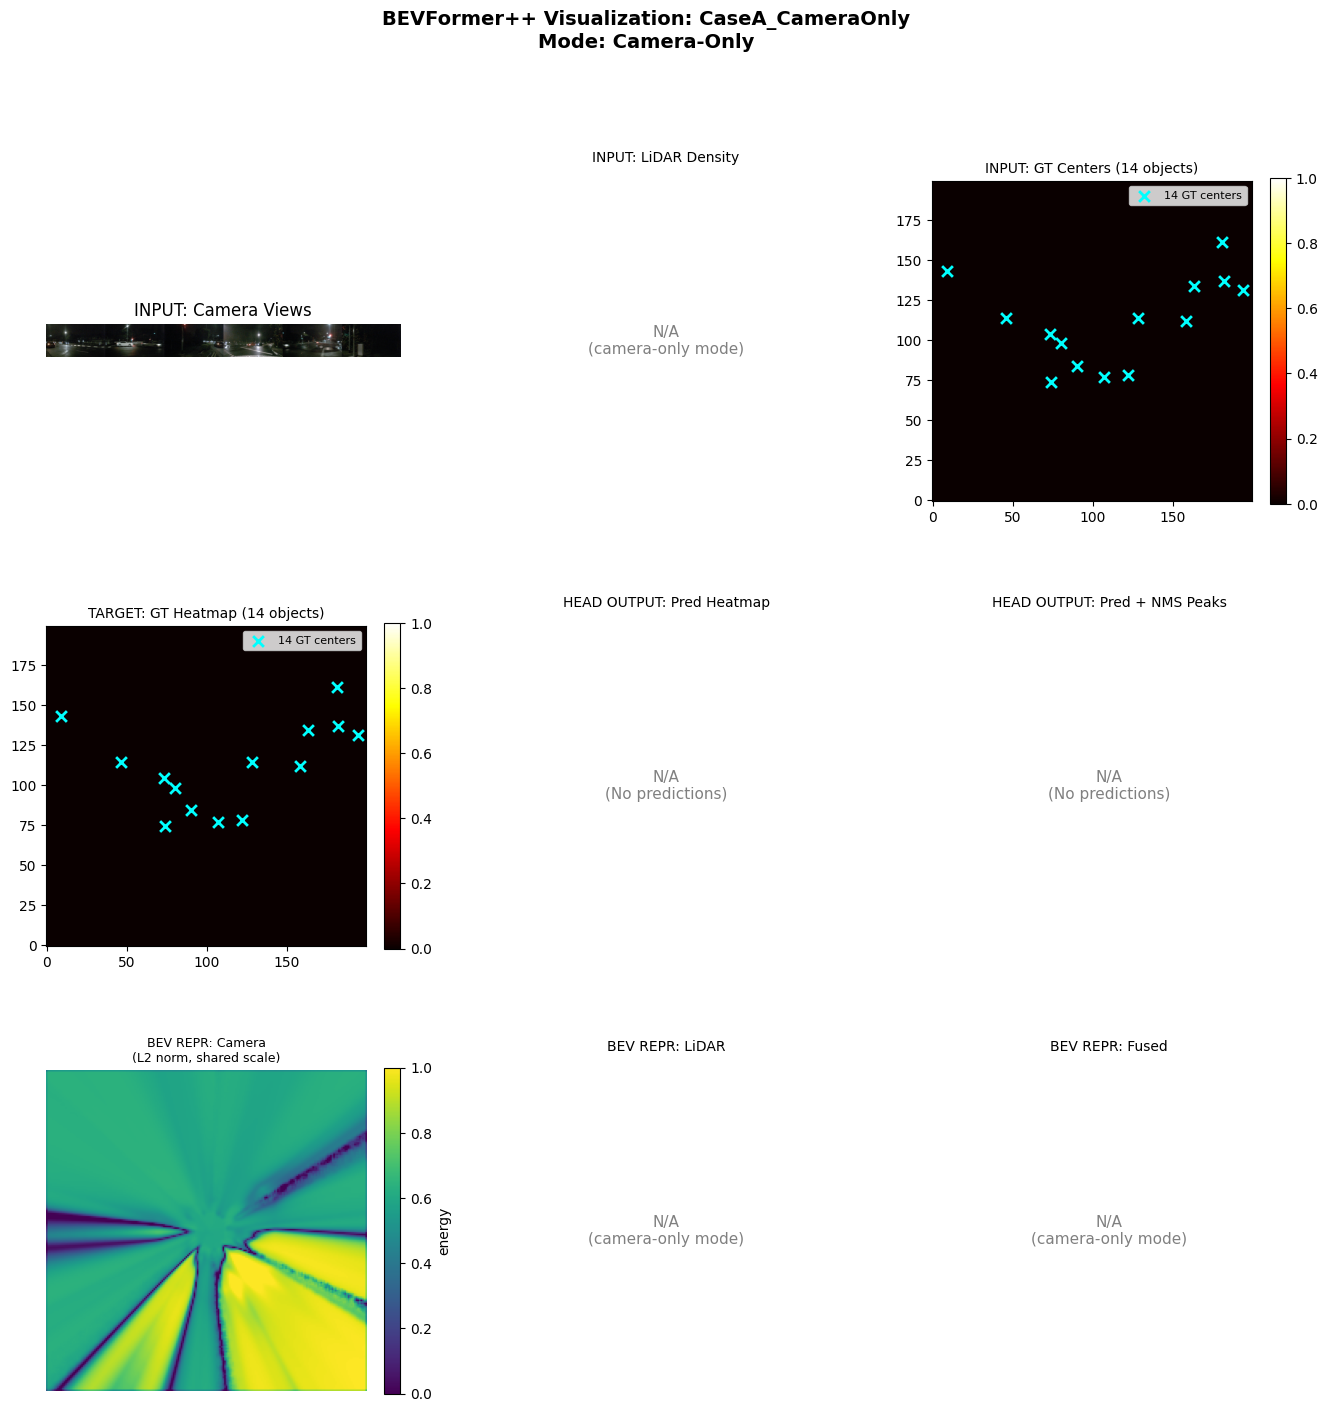

In [35]:
# ============================================================================
# CREATE VISUALIZATION FIGURE: CASE A (Camera-Only)
# ============================================================================
# Uses the new visualize_bevformer_case() API with strict mode semantics

fig_a = visualize_bevformer_case(
    batch=batch_a,
    preds=preds_a,
    tensors=tensors_a,
    case_name='CaseA_CameraOnly',
    output_dir=VIS_OUTPUT_DIR,
    mode='camera_only',  # EXPLICIT: LiDAR and Fused will show N/A
)
plt.show()



=== Debug Stats: CaseB_Fusion (fusion) ===
Captured tensor keys: ['camera_bev', 'lidar_bev', 'fused_bev', 'mc_convrnn_bev']
Prediction keys: ['cls_scores', 'bbox_preds']

--- BEV Feature Tensors ---
  [camera_bev]
    shape: [1, 256, 200, 200], dtype: torch.float32
    range: [-4.6709, 4.6372]
    mean: -0.0000, std: 1.0000
    percentiles: p1=-2.3502, p50=0.0087, p99=2.2970
  [lidar_bev]
    shape: [1, 64, 200, 200], dtype: torch.float16
    range: [0.0000, 1.7217]
    mean: 0.0201, std: 0.0517
    percentiles: p1=0.0000, p50=0.0025, p99=0.2568
  [fused_bev]
    shape: [1, 256, 200, 200], dtype: torch.float16
    range: [0.0000, 1.5430]
    mean: 0.1899, std: 0.2744
    percentiles: p1=0.0000, p50=0.0030, p99=1.0645

--- Prediction Tensors ---
  [pred_heatmap]
    shape: [1, 10, 200, 200], dtype: torch.float16
    range: [-2.2305, -2.1699]
    mean: -2.2008, std: 0.0132
    percentiles: p1=-2.2246, p50=-2.2031, p99=-2.1758
✓ Saved: outputs/vis_20260102_154538/fig_CaseB_Fusion.png
✓ S

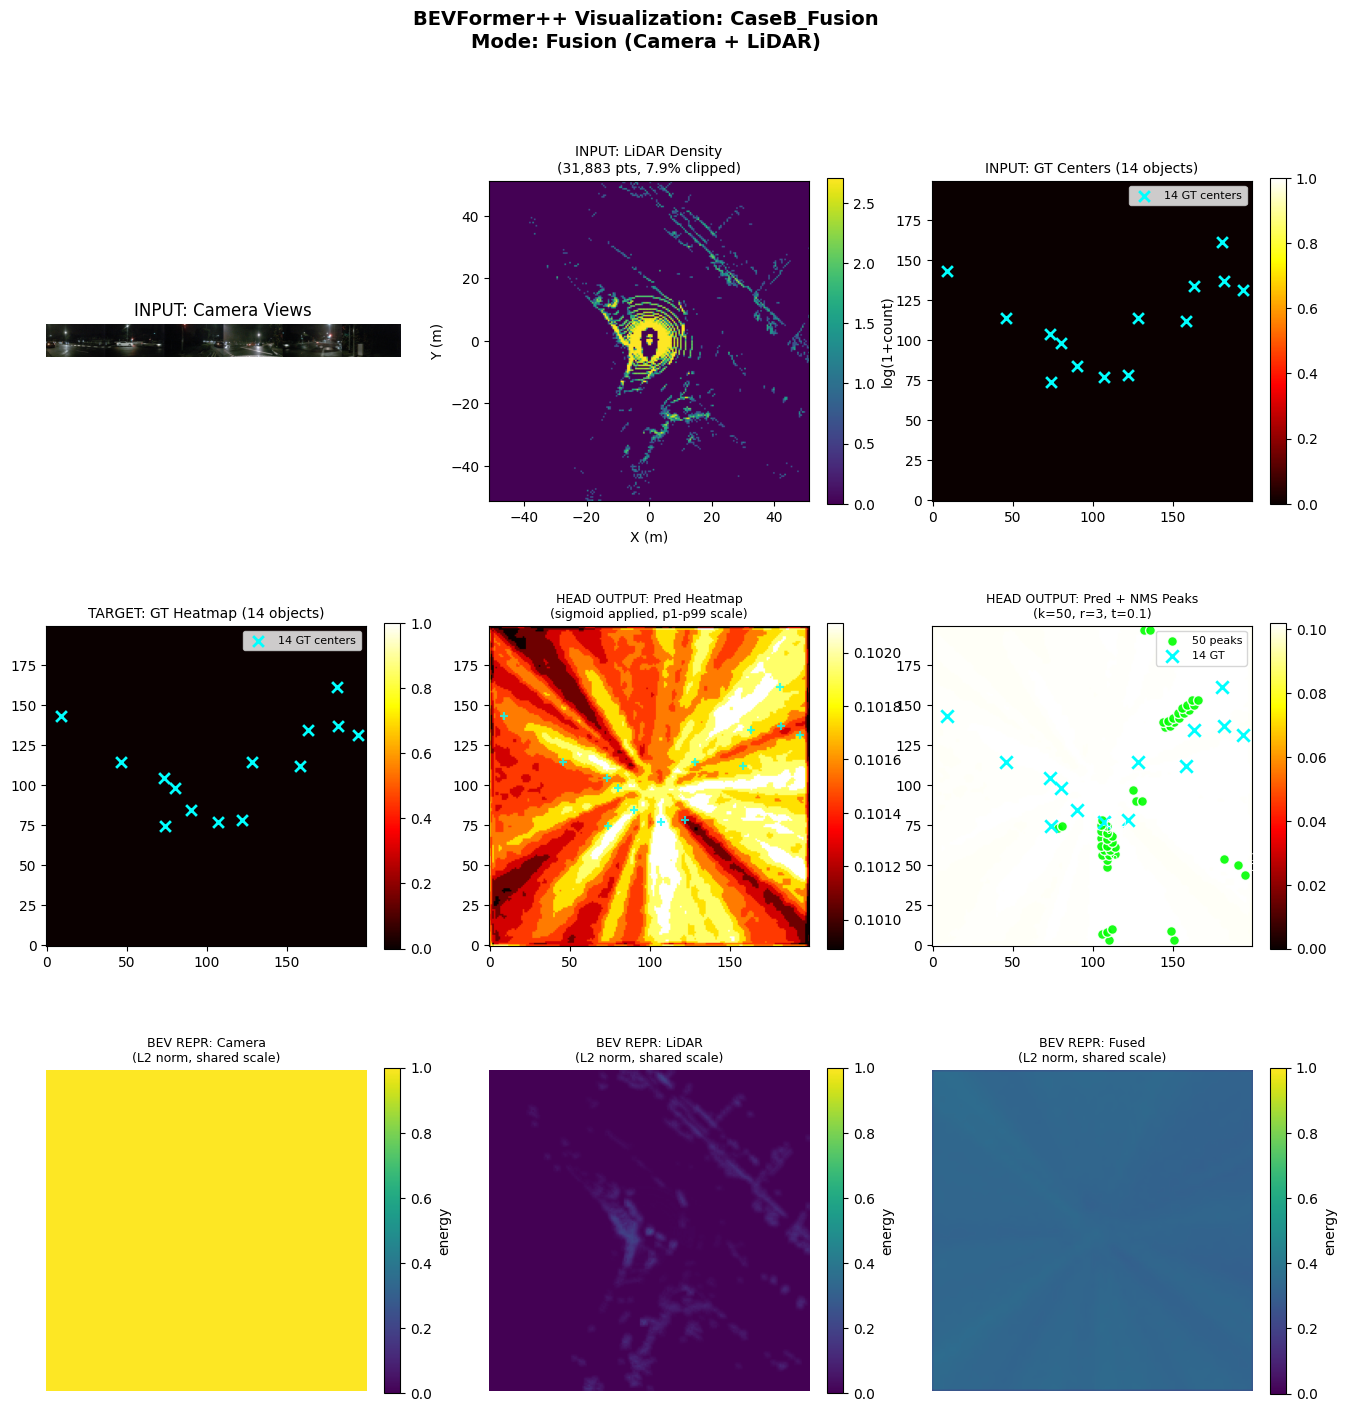

In [36]:
# ============================================================================
# CREATE VISUALIZATION FIGURE: CASE B (Fusion)
# ============================================================================
# Uses the new visualize_bevformer_case() API with strict mode semantics

if case_b_available:
    fig_b = visualize_bevformer_case(
        batch=batch_b,
        preds=preds_b,
        tensors=tensors_b,
        case_name='CaseB_Fusion',
        output_dir=VIS_OUTPUT_DIR,
        mode='fusion',  # EXPLICIT: All three BEV features expected
    )
    plt.show()
else:
    print("⚠️ Case B (Fusion) not available")
    print("  Run fusion training first:")
    print("  python train.py --config configs/debug.yaml --use_lidar --use_fusion --epochs 3")


---
## 8. Quantitative Sanity Check

In [37]:
# ============================================================================
# QUANTITATIVE SANITY CHECK
# ============================================================================
# Compute metrics to verify visualization correctness

from modules.vis import extract_nms_peaks, get_gt_centers
import torch

def compute_visualization_metrics(preds, targets, k=50, radius=3, thresh=0.1):
    """
    Compute quantitative metrics for visualization sanity check.
    
    Returns:
        pos_mean: Mean prediction probability at GT center locations
        neg_mean: Mean prediction probability at background locations
        n_peaks: Number of NMS peaks detected
        mean_peak_to_gt: Average distance from peaks to nearest GT
        peaks_hitting_gt: Number of peaks within 5px of a GT center
    """
    metrics = {}
    
    # Get prediction heatmap
    pred_heatmap = None
    for key in ['cls_scores', 'cls_pred', 'heatmap', 'cls', 'output']:
        if key in preds:
            pred_heatmap = preds[key]
            break
    
    if pred_heatmap is None:
        return {'error': 'No prediction heatmap found'}
    
    # Apply sigmoid
    h = pred_heatmap.detach()
    if h.dim() == 4:
        h = h[0]
    h_prob = torch.sigmoid(h).max(dim=0)[0].cpu().numpy()  # (H, W)
    
    # Get GT targets
    t = targets.detach()
    if t.dim() == 4:
        t = t[0]
    gt = t.max(dim=0)[0].cpu().numpy()  # (H, W)
    
    # Positive/negative masks
    pos_mask = gt > 0.5
    neg_mask = gt < 0.1
    
    if pos_mask.sum() > 0:
        metrics['pos_mean'] = float(h_prob[pos_mask].mean())
    else:
        metrics['pos_mean'] = None
    
    if neg_mask.sum() > 0:
        # Subsample for speed
        neg_vals = h_prob[neg_mask]
        if len(neg_vals) > 10000:
            import numpy as np
            neg_vals = np.random.choice(neg_vals, 10000, replace=False)
        metrics['neg_mean'] = float(neg_vals.mean())
    else:
        metrics['neg_mean'] = None
    
    # Extract NMS peaks
    peaks = extract_nms_peaks(pred_heatmap, k=k, radius=radius, thresh=thresh)
    metrics['n_peaks'] = len(peaks)
    
    # Get GT centers
    gt_centers = get_gt_centers(targets)
    metrics['n_gt'] = len(gt_centers)
    
    # Compute peak-to-GT distances
    if len(peaks) > 0 and len(gt_centers) > 0:
        import numpy as np
        distances = []
        for peak in peaks:
            min_dist = float('inf')
            for gt in gt_centers:
                d = np.sqrt((peak.y - gt[0])**2 + (peak.x - gt[1])**2)
                min_dist = min(min_dist, d)
            distances.append(min_dist)
        
        metrics['mean_peak_to_gt'] = float(np.mean(distances))
        metrics['peaks_within_5px'] = sum(1 for d in distances if d < 5)
        metrics['peaks_within_10px'] = sum(1 for d in distances if d < 10)
    
    return metrics


# Compute metrics for Case A
print("\n" + "="*60)
print("QUANTITATIVE METRICS")
print("="*60)

metrics_a = compute_visualization_metrics(preds_a, batch_a['cls_targets'])
print(f"\nCase A (Camera-Only):")
print(f"  GT objects:           {metrics_a.get('n_gt', 'N/A')}")
print(f"  Detected peaks:       {metrics_a.get('n_peaks', 'N/A')}")
if metrics_a.get('pos_mean') is not None:
    print(f"  pos_mean (pred@GT):   {metrics_a['pos_mean']:.4f}")
if metrics_a.get('neg_mean') is not None:
    print(f"  neg_mean (pred@bg):   {metrics_a['neg_mean']:.4f}")
if 'mean_peak_to_gt' in metrics_a:
    print(f"  Mean peak→GT dist:    {metrics_a['mean_peak_to_gt']:.1f} px")
    print(f"  Peaks within 5px:     {metrics_a['peaks_within_5px']}")

if case_b_available:
    metrics_b = compute_visualization_metrics(preds_b, batch_b['cls_targets'])
    print(f"\nCase B (Fusion):")
    print(f"  GT objects:           {metrics_b.get('n_gt', 'N/A')}")
    print(f"  Detected peaks:       {metrics_b.get('n_peaks', 'N/A')}")
    if metrics_b.get('pos_mean') is not None:
        print(f"  pos_mean (pred@GT):   {metrics_b['pos_mean']:.4f}")
    if metrics_b.get('neg_mean') is not None:
        print(f"  neg_mean (pred@bg):   {metrics_b['neg_mean']:.4f}")
    if 'mean_peak_to_gt' in metrics_b:
        print(f"  Mean peak→GT dist:    {metrics_b['mean_peak_to_gt']:.1f} px")
        print(f"  Peaks within 5px:     {metrics_b['peaks_within_5px']}")
    
    # Comparison
    print(f"\n--- Comparison (B vs A) ---")
    if metrics_a.get('pos_mean') and metrics_b.get('pos_mean'):
        delta = metrics_b['pos_mean'] - metrics_a['pos_mean']
        print(f"  pos_mean delta: {delta:+.4f} {'↑ better' if delta > 0 else '↓ worse'}")
    if metrics_a.get('neg_mean') and metrics_b.get('neg_mean'):
        delta = metrics_b['neg_mean'] - metrics_a['neg_mean']
        print(f"  neg_mean delta: {delta:+.4f} {'↓ better' if delta < 0 else '↑ worse'}")



QUANTITATIVE METRICS

Case A (Camera-Only):
  GT objects:           N/A
  Detected peaks:       N/A

Case B (Fusion):
  GT objects:           14
  Detected peaks:       50
  pos_mean (pred@GT):   0.1017
  neg_mean (pred@bg):   0.1016
  Mean peak→GT dist:    26.4 px
  Peaks within 5px:     4

--- Comparison (B vs A) ---


---
## 9. Paper Caption & Notes

In [38]:
# ============================================================================
# PAPER-READY CAPTION AND NOTES
# ============================================================================

PAPER_CAPTION = """
**Figure: Qualitative comparison of camera-only baseline (Case A) vs. proposed fusion model (Case B).**

*Row 1*: Input modalities - multi-view camera images, LiDAR BEV density map (Case B only), and ground-truth object centers.
*Row 2*: Classification heatmaps - ground-truth targets, model predictions (after sigmoid), and top-K peak detections.
*Row 3*: Intermediate BEV features - camera-derived BEV (from BEVFormer), LiDAR-derived BEV (Case B only), and fused representation.

Effective fusion is indicated by: (1) sharper, more localized peaks in the predicted heatmap, 
(2) reduced background noise compared to camera-only baseline, and (3) better alignment of predicted peaks with GT centers.
"""

PAPER_NOTES = [
    "• Row 1: Sanity check inputs - verify data loading and BEV grid alignment.",
    "• Row 2: Core detection comparison - sharper peaks and lower background indicate better discrimination.",
    "• Row 3: Feature-level evidence - fused features should show complementary information from both modalities.",
    "• Improvement indicators: higher pos_mean, lower neg_mean, smaller peak_distance.",
    "• CAUTION: Qualitative evidence only - must be paired with quantitative mAP/NDS metrics for publication.",
    "• If Case B unavailable: train fusion model first using train.py --use_fusion.",
]

print("="*80)
print("PAPER CAPTION")
print("="*80)
print(PAPER_CAPTION)

print("\n" + "="*80)
print("PAPER NOTES")
print("="*80)
for note in PAPER_NOTES:
    print(note)

PAPER CAPTION

**Figure: Qualitative comparison of camera-only baseline (Case A) vs. proposed fusion model (Case B).**

*Row 1*: Input modalities - multi-view camera images, LiDAR BEV density map (Case B only), and ground-truth object centers.
*Row 2*: Classification heatmaps - ground-truth targets, model predictions (after sigmoid), and top-K peak detections.
*Row 3*: Intermediate BEV features - camera-derived BEV (from BEVFormer), LiDAR-derived BEV (Case B only), and fused representation.

Effective fusion is indicated by: (1) sharper, more localized peaks in the predicted heatmap, 
(2) reduced background noise compared to camera-only baseline, and (3) better alignment of predicted peaks with GT centers.


PAPER NOTES
• Row 1: Sanity check inputs - verify data loading and BEV grid alignment.
• Row 2: Core detection comparison - sharper peaks and lower background indicate better discrimination.
• Row 3: Feature-level evidence - fused features should show complementary information from

In [39]:
# ============================================================================
# SUMMARY & VERIFICATION CHECKLIST
# ============================================================================

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)
print(f"\nOutput directory: {VIS_OUTPUT_DIR}")
print(f"\nFiles saved:")
for f in VIS_OUTPUT_DIR.iterdir():
    print(f"  - {f.name} ({f.stat().st_size / 1024:.1f} KB)")

# ============================================================================
# VERIFICATION CHECKLIST (Expected Outcomes)
# ============================================================================
print("\n" + "="*80)
print("VERIFICATION CHECKLIST")
print("="*80)

print("""
CASE A (Camera-Only):
  [?] Pred heatmap visible (Row 2, labeled "HEAD OUTPUT")
  [?] Camera BEV energy map shows structure (not saturated yellow)
  [?] LiDAR BEV shows "N/A (camera-only mode)"
  [?] Fused BEV shows "N/A (camera-only mode)"
  [?] No RuntimeError from tensor boolean checks

CASE B (Fusion):
  [?] Pred heatmap visible (Row 2, labeled "HEAD OUTPUT")
  [?] Camera BEV energy map visible (Row 3)
  [?] LiDAR BEV energy map visible (Row 3)
  [?] Fused BEV energy map visible (NOT "N/A")
  [?] Shared normalization makes Row 3 panels comparable
  [?] No "Hook not captured" for fused_bev

SEMANTIC SEPARATION:
  [?] Row 2 clearly labeled "HEAD OUTPUT" (not "BEV feature")
  [?] Row 3 clearly labeled "BEV REPR" (intermediate features)

DEBUG STATS (check console output):
  [?] Each tensor shows: shape, dtype, min/max, mean/std, p1/p50/p99
  [?] Low dynamic range warning if p99-p1 < 1e-6
""")

print("\nTo reproduce:")
print(f"  1. Ensure checkpoints exist: {CASE_A_CHECKPOINT}, {CASE_B_CHECKPOINT}")
print(f"  2. Re-run this notebook with SEED={SEED}")
print(f"  3. Compare figures in {VIS_OUTPUT_DIR}")



VISUALIZATION COMPLETE

Output directory: outputs/vis_20260102_154538

Files saved:
  - fig_CaseA_CameraOnly.pdf (129.2 KB)
  - fig_CaseA_CameraOnly.png (364.7 KB)
  - fig_CaseB_Fusion.pdf (210.4 KB)
  - fig_CaseB_Fusion.png (563.8 KB)

VERIFICATION CHECKLIST

CASE A (Camera-Only):
  [?] Pred heatmap visible (Row 2, labeled "HEAD OUTPUT")
  [?] Camera BEV energy map shows structure (not saturated yellow)
  [?] LiDAR BEV shows "N/A (camera-only mode)"
  [?] Fused BEV shows "N/A (camera-only mode)"
  [?] No RuntimeError from tensor boolean checks

CASE B (Fusion):
  [?] Pred heatmap visible (Row 2, labeled "HEAD OUTPUT")
  [?] Camera BEV energy map visible (Row 3)
  [?] LiDAR BEV energy map visible (Row 3)
  [?] Fused BEV energy map visible (NOT "N/A")
  [?] Shared normalization makes Row 3 panels comparable
  [?] No "Hook not captured" for fused_bev

SEMANTIC SEPARATION:
  [?] Row 2 clearly labeled "HEAD OUTPUT" (not "BEV feature")
  [?] Row 3 clearly labeled "BEV REPR" (intermediate f